# Project Description


Work as a Data Scientist for a financial company named "Prêt à dépenser," which offers consumer credit to individuals with little or no credit history.

The company wants to develop a scoring model to predict the probability of customer default in order to support the decision of whether or not to grant a loan to a potential customer, using various data sources (behavioral data, data from other financial institutions, etc.).

Additionally, the customer relationship managers have reported that clients are increasingly requesting more transparency regarding the credit approval decisions. This demand for transparency aligns perfectly with the values the company aims to embody.

Therefore, the company has decided to develop an interactive dashboard so that customer relationship managers can not only explain credit approval decisions as transparently as possible but also allow their clients to access and explore their personal information easily.

# Importing Libraries

In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import missingno as msno
import gc
from contextlib import contextmanager
import time

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_row', 500)

# Functions

In [11]:
@contextmanager
def timer(title):
    t0 = time.time ()
    yield
    print ("{} - done in {:.0f}s".format (title, time.time () - t0))

#path="/kaggle/input/homecredit/home_credit_default_risk_dataset/"
path = "./data/"

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list (df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies (df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv (path+'/application_train.csv', nrows=num_rows)
    test_df = pd.read_csv (path+'/application_test.csv', nrows=num_rows)
    print ("Train samples: {}, test samples: {}".format (len (df), len (test_df)))
    df = pd.concat([df, test_df]).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize (df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder (df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace (365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect ()
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv (path+'/bureau.csv', nrows=num_rows)
    bb = pd.read_csv (path+'/bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder (bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder (bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = { 'MONTHS_BALANCE': ['min', 'max', 'size'] }
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby ('SK_ID_BUREAU').agg (bb_aggregations)
    bb_agg.columns = pd.Index ([e[0] + "_" + e[1].upper () for e in bb_agg.columns.tolist ()])
    bureau = bureau.join (bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop (['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect ()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = { }
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby ('SK_ID_CURR').agg ({ **num_aggregations, **cat_aggregations })
    bureau_agg.columns = pd.Index (['BURO_' + e[0] + "_" + e[1].upper () for e in bureau_agg.columns.tolist ()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby ('SK_ID_CURR').agg (num_aggregations)
    active_agg.columns = pd.Index (['ACTIVE_' + e[0] + "_" + e[1].upper () for e in active_agg.columns.tolist ()])
    bureau_agg = bureau_agg.join (active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect ()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby ('SK_ID_CURR').agg (num_aggregations)
    closed_agg.columns = pd.Index (['CLOSED_' + e[0] + "_" + e[1].upper () for e in closed_agg.columns.tolist ()])
    bureau_agg = bureau_agg.join (closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect ()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv (path+'/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder (prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace (365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace (365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace (365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace (365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace (365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = { }
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby ('SK_ID_CURR').agg ({ **num_aggregations, **cat_aggregations })
    prev_agg.columns = pd.Index (['PREV_' + e[0] + "_" + e[1].upper () for e in prev_agg.columns.tolist ()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby ('SK_ID_CURR').agg (num_aggregations)
    approved_agg.columns = pd.Index (['APPROVED_' + e[0] + "_" + e[1].upper () for e in approved_agg.columns.tolist ()])
    prev_agg = prev_agg.join (approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby ('SK_ID_CURR').agg (num_aggregations)
    refused_agg.columns = pd.Index (['REFUSED_' + e[0] + "_" + e[1].upper () for e in refused_agg.columns.tolist ()])
    prev_agg = prev_agg.join (refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect ()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv (path+'/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder (pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby ('SK_ID_CURR').agg (aggregations)
    pos_agg.columns = pd.Index (['POS_' + e[0] + "_" + e[1].upper () for e in pos_agg.columns.tolist ()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby ('SK_ID_CURR').size ()
    del pos
    gc.collect ()
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv (path+'/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder (ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply (lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply (lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby ('SK_ID_CURR').agg (aggregations)
    ins_agg.columns = pd.Index (['INSTAL_' + e[0] + "_" + e[1].upper () for e in ins_agg.columns.tolist ()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby ('SK_ID_CURR').size ()
    del ins
    gc.collect ()
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv (path+'/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder (cc, nan_as_category=True)
    # General aggregations
    cc.drop (['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby ('SK_ID_CURR').agg (['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index (['CC_' + e[0] + "_" + e[1].upper () for e in cc_agg.columns.tolist ()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby ('SK_ID_CURR').size ()
    del cc
    gc.collect ()
    return cc_agg


# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull ()]
    test_df = df[df['TARGET'].isnull ()]
    print ("Starting LightGBM. Train shape: {}, test shape: {}".format (train_df.shape, test_df.shape))
    del df
    gc.collect ()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold (n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold (n_splits=num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros (train_df.shape[0])
    sub_preds = np.zeros (test_df.shape[0])
    feature_importance_df = pd.DataFrame ()
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate (folds.split (train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier (
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit (train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                 eval_metric='auc', verbose=200, early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba (valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba (test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame ()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat ([feature_importance_df, fold_importance_df], axis=0)
        print ('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score (valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect ()

    print ('Full AUC score %.6f' % roc_auc_score (train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('sample_submission.csv', index=False)
    display_importances (feature_importance_df)
    return feature_importance_df

def preprocess_data_home_credit_default(file_name, debug = False):
    '''Function to preprocess and aggregate in one df features+target of clients and saving in the current working directory a csv file
    - debug --> otpion to test our function with only a fraction of rows in the data
    - file_name --> must be an str, name of the final csv file return by the function'''
    
    init_time = time.time()
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    print(f'Main df init shape: {df.shape}')
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
    print(f'Main df final shape: {df.shape}')
    df.to_csv(f'{file_name}.csv')
    print(f'Function executed in : {time.time() - init_time} s')   



# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby ("feature").mean ().sort_values (by="importance",
                                                                                                      ascending=False)[
           :40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin (cols)]
    plt.figure (figsize=(8, 10))
    sns.barplot (x="importance", y="feature", data=best_features.sort_values (by="importance", ascending=False))
    plt.title ('LightGBM Features (avg over folds)')
    plt.tight_layout ()
    plt.savefig ('lgbm_importances01.png')


def target_corrs(df):
    '''List of correlations'''
    corrs = []

    # Iterate through the columns
    for col in df.columns:
        print (col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr (df[col])

            # Append the list as a tuple
            corrs.append ((col, corr))

    # Sort by absolute magnitude of correlations
    corrs = sorted (corrs, key=lambda x: abs (x[1]), reverse=True)

    return corrs


def kde_target(df, var_name, target='TARGET'):
    '''Plots the disribution of a variable colored by value of the target'''

    # Calculate the correlation coefficient between the new variable and the target
    corr = df[target].corr (df[var_name])
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df[target] == 0, var_name].median ()
    avg_not_repaid = df.loc[df[target] == 1, var_name].median ()

    plt.figure (figsize=(12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot (df.loc[df[target] == 0, var_name], label='TARGET == 0')
    sns.kdeplot (df.loc[df[target] == 1, var_name], label='TARGET == 1')

    # label the plot
    plt.xlabel (var_name);
    plt.ylabel ('Density')
    plt.title ('%s Distribution' % var_name)
    plt.legend ()

    # print out the correlation
    print ('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print ('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print ('Median value for loan that was repaid =     %0.4f' % avg_repaid)

def Pie_chart2(df) :
    tot_null =  df.isna().sum().sum()
    prop = tot_null*100/(df.shape[0]*df.shape[1])
    data = [prop,100-prop]
    labels = ['Null', 'Donnée']
    plt.figure(figsize=(15,8))
    fig = px.pie(df, values=data, names=labels, title='Taux de Remplissage')
    fig.show()
    
    
def nan_control(df):
    fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(25,10))
    msno.matrix(df,ax=plt.subplot(211))
    msno.bar(df,ax=plt.subplot(212))
    
def remplissage(df):
    df_sort = pd.DataFrame(round(df.shape[0] - df.isna().sum())/df.shape[0],columns=\
                               ['Taux_de_remplissage']).sort_values('Taux_de_remplissage', ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(10,30))
    
    sns.barplot(y=df_sort['index'], x='Taux_de_remplissage', data=df_sort)

    plt.title('Taux de remplissage des variables - %', fontsize = 30)
    plt.show()

# Importing Datasets

In [12]:
#path = "/kaggle/input/homecredit/home_credit_default_risk_dataset/"
path = "./data/"

In [13]:
os.listdir(path)

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

## HomeCredit_columns_description.csv

<ul>
    <li>
        This file contains descriptions for the columns in the various data files.
    </li>
</ul>

In [17]:
df_home_credit = pd.read_csv(path+'/HomeCredit_columns_description.csv', encoding= 'unicode_escape')
df_home_credit

Unnamed: 0                         Table                           Row                                                                                                                                                                                                                                                                           Description                                Special
0             1  application_{train|test}.csv                    SK_ID_CURR                                                                                                                                                                                                                                                              ID of loan in our sample                                    NaN
1             2  application_{train|test}.csv                        TARGET                                                                                           Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)                                    NaN
2             5  application_{train|test}.csv            NAME_CONTRACT_TYPE                                                                                                                                                                                                                                           Identification if loan is cash or revolving                                    NaN
3             6  application_{train|test}.csv                   CODE_GENDER                                                                                                                                                                                                                                                                  Gender of the client                                    NaN
4             7  application_{train|test}.csv                  FLAG_OWN_CAR                                                                                                                                                                                                                                                         Flag if the client owns a car                                    NaN
5             8  application_{train|test}.csv               FLAG_OWN_REALTY                                                                                                                                                                                                                                                   Flag if client owns a house or flat                                    NaN
6             9  application_{train|test}.csv                  CNT_CHILDREN                                                                                                                                                                                                                                                     Number of children the client has                                    NaN
7            10  application_{train|test}.csv              AMT_INCOME_TOTAL                                                                                                                                                                                                                                                                  Income of the client                                    NaN
8            11  application_{train|test}.csv                    AMT_CREDIT                                                                                                                                                                                                                                                             Credit amount of the loan                                    NaN
9            12  application_{train|test}.csv                   AMT_ANNUITY

In [37]:
df_home_credit.shape

(219, 5)

In [38]:
df_home_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


In [18]:
print(f'Descriptions of {df_home_credit['Table'].nunique()} tables : {df_home_credit['Table'].unique()}')

Descriptions of 7 tables : ['application_{train|test}.csv' 'bureau.csv' 'bureau_balance.csv'
 'POS_CASH_balance.csv' 'credit_card_balance.csv'
 'previous_application.csv' 'installments_payments.csv']


## application_train.csv et application_test.csv

<ul>
    <li>
        This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    </li>
    <li>
        Static data for all applications. One row represents one loan in our data sample.
    </li>
</ul>

In [19]:
df_train = pd.read_csv(path+'/application_train.csv',)
df_train= df_train.loc[:, ~df_train.columns.str.match('Unnamed')]
df_train.tail(3)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR
307508      456253       0         Cash loans           F            N               Y             0          153000.0    677664.0      29979.0  ...                 0                0                0                0                        1.0                       0.0                         0.0                        1.0                        0.0                         1.0
307509      456254       1         Cash loans           F            N               Y             0          171000.0    370107.0      20205.0  ...                 0                0                0                0                        0.0                       0.0                         0.0                        0.0                        0.0                         0.0
307510      456255       0         Cash loans           F            N               N             0          157500.0    675000.0      49117.5  ...                 0                0                0                0                        0.0                       0.0                         0.0                        2.0                        0.0                         1.0

[3 rows x 122 columns]

In [20]:
df_train.shape

(307511, 122)

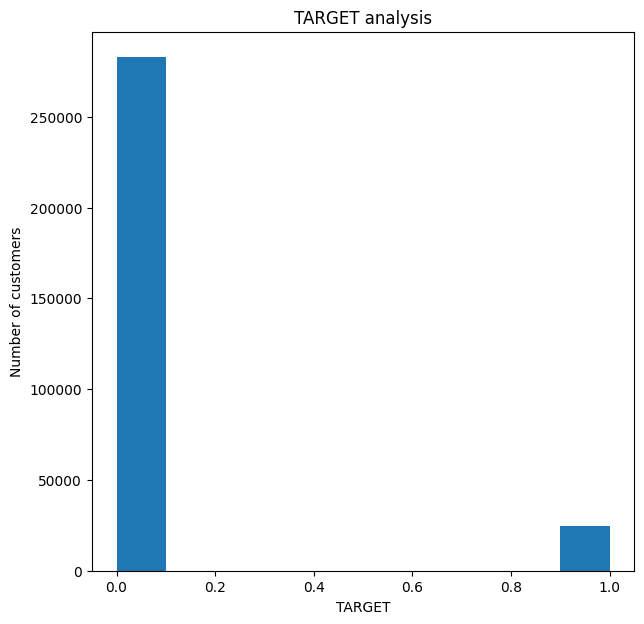

In [21]:
plt.figure(figsize=(7,7))
plt.hist(df_train['TARGET'].astype(int))
plt.title('TARGET analysis')
plt.xlabel('TARGET')
plt.ylabel('Number of customers')
plt.show()

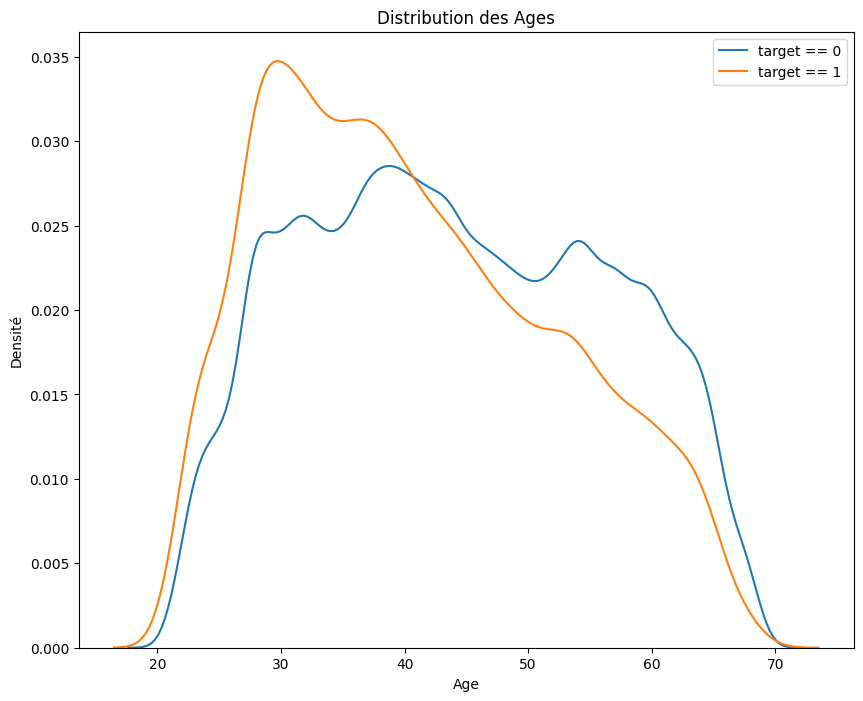

In [22]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(abs(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH']) / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(abs(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH']) / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age'); plt.ylabel('Densité'); plt.title('Distribution des Ages')

plt.legend()
plt.show()

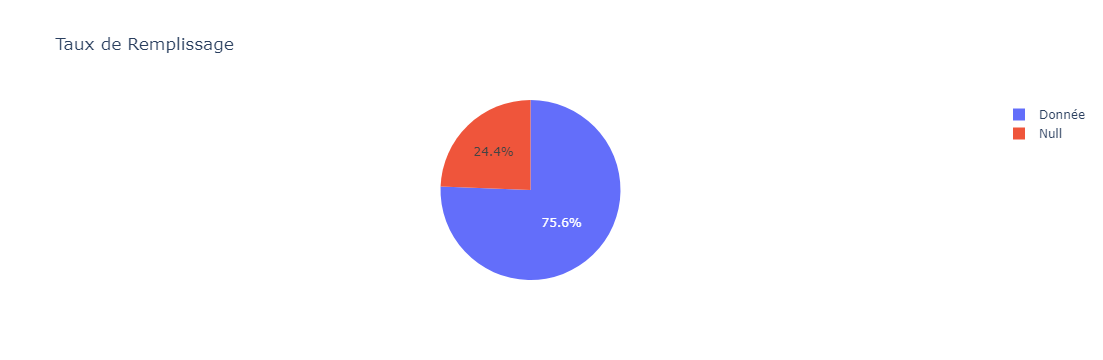

<Figure size 1500x800 with 0 Axes>

In [23]:
Pie_chart2(df_train)

In [24]:
remplissage(df_train)

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [26]:
df_train.describe(include = 'all')

SK_ID_CURR         TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR
count   307511.000000  307511.000000             307511      307511       307511          307511  307511.000000      3.075110e+05  3.075110e+05  307499.000000  ...     307511.000000    307511.000000    307511.000000    307511.000000              265992.000000             265992.000000               265992.000000              265992.000000              265992.000000               265992.000000
unique            NaN            NaN                  2           3            2               2            NaN               NaN           NaN            NaN  ...               NaN              NaN              NaN              NaN                        NaN                       NaN                         NaN                        NaN                        NaN                         NaN
top               NaN            NaN         Cash loans           F            N               Y            NaN               NaN           NaN            NaN  ...               NaN              NaN              NaN              NaN                        NaN                       NaN                         NaN                        NaN                        NaN                         NaN
freq              NaN            NaN             278232      202448       202924          213312            NaN               NaN           NaN            NaN  ...               NaN              NaN              NaN              NaN                        NaN                       NaN                         NaN                        NaN                        NaN                         NaN
mean    278180.518577       0.080729                NaN         NaN          NaN             NaN       0.417052      1.687979e+05  5.990260e+05   27108.573909  ...          0.008130         0.000595         0.000507         0.000335                   0.006402                  0.007000                    0.034362                   0.267395                   0.265474                    1.899974
std     102790.175348       0.272419                NaN         NaN          NaN             NaN       0.722121      2.371231e+05  4.024908e+05   14493.737315  ...          0.089798         0.024387         0.022518         0.018299                   0.083849                  0.110757                    0.204685                   0.916002                   0.794056                    1.869295
min     100002.000000       0.000000                NaN         NaN          NaN             NaN       0.000000      2.565000e+04  4.500000e+04    1615.500000  ...          0.000000         0.000000         0.000000         0.000000                   0.000000                  0.000000                    0.000000                   0.000000                   0.000000                    0.000000
25%     189145.500000       0.000000                NaN         NaN          NaN             NaN       0.000000      1.125000e+05  2.700000e+05   16524.000000  ...          0.000000         0.000000         0.000000         0.000000                   0.000000                  0.000000                    0.000000                   0.000000                   0.000000                    0.000000
50%     278202.000000       0.000000                NaN         NaN          NaN             NaN       0.000000      1.471500e+05  5.135310e+05   24903.000000  ...          0.000000         0.000000         0.000000         0.000000                   0.000000                  0.000000                    0.000000                   0.000000                   0.000000                    1.000000
75%     367142.500000       0.000000               

In [27]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919    0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846   -0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167   -0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000   -0.205478
DAYS_BIRTH    0.078239     -0.600610     -0.091996     -0.205478    1.000000

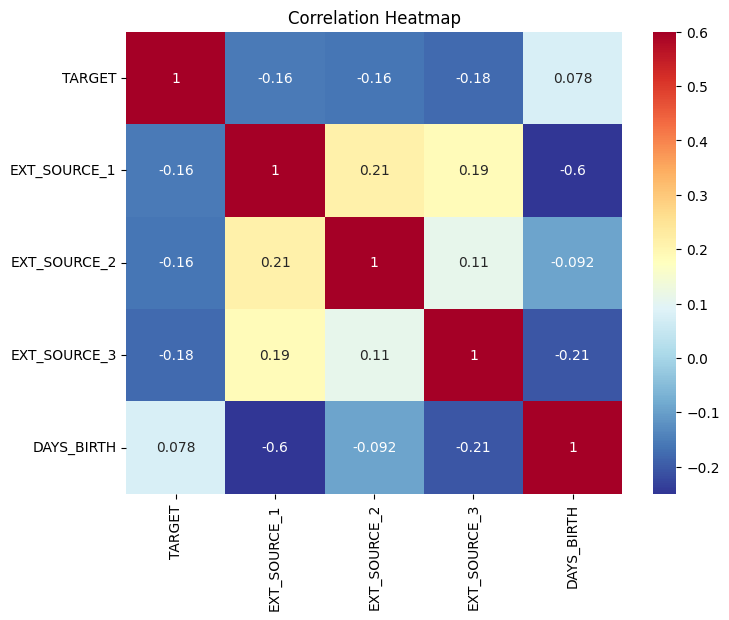

In [28]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt.
Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible.
Cela nous permettra de visualiser l'effet de cette variable sur la cible.


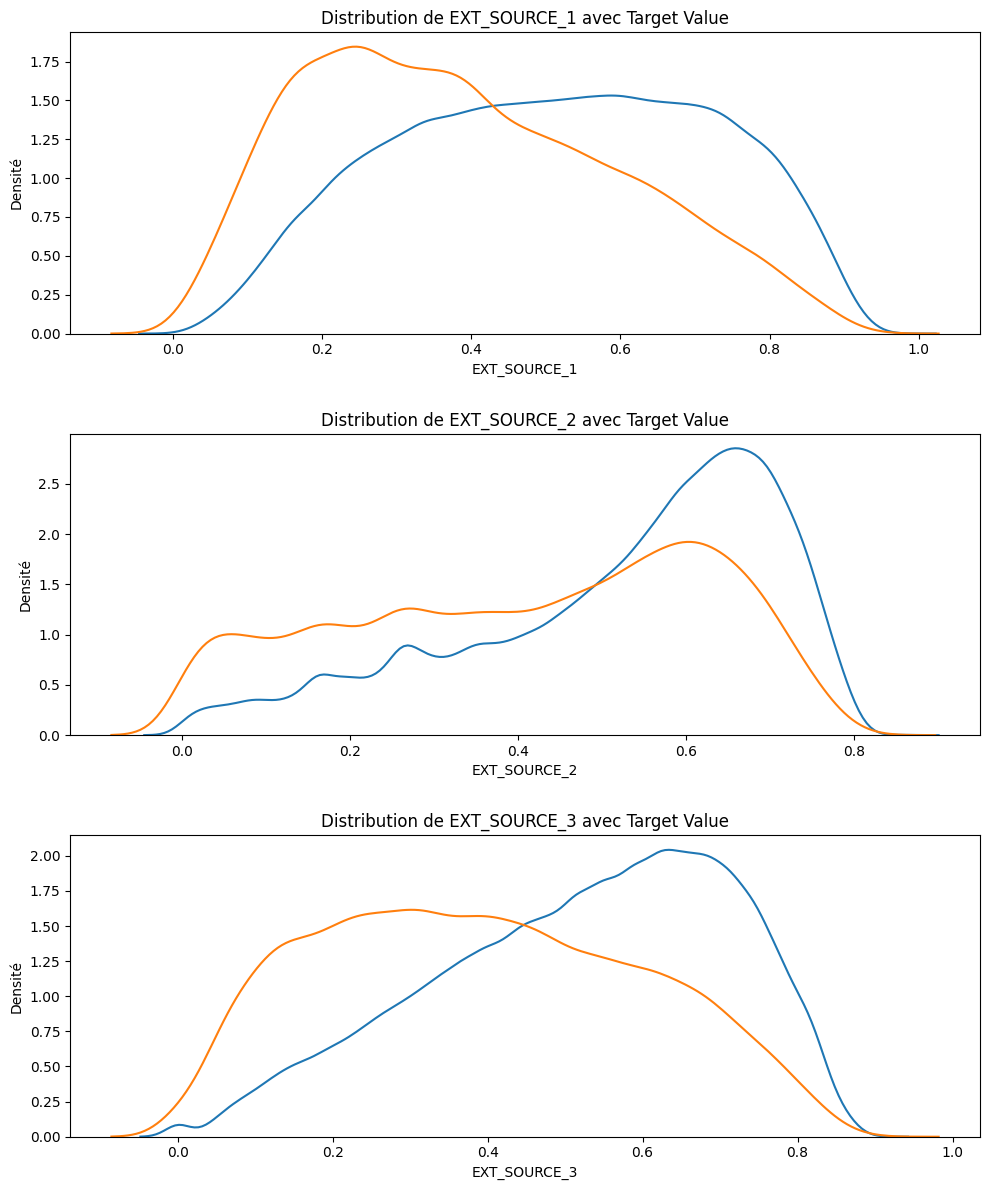

In [29]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution de %s avec Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité');
    
plt.tight_layout(h_pad = 2.5)

In [30]:
df_test = pd.read_csv(path+'/application_test.csv')
df_test= df_test.loc[:, ~df_test.columns.str.match('Unnamed')]
df_test.tail(3)

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR
48741      456223         Cash loans           F            Y               Y             1          202500.0    315000.0      33205.5         315000.0  ...                0                0                0                0                        0.0                        0.0                         0.0                        0.0                        3.0                         1.0
48742      456224         Cash loans           M            N               N             0          225000.0    450000.0      25128.0         450000.0  ...                0                0                0                0                        0.0                        0.0                         0.0                        0.0                        0.0                         2.0
48743      456250         Cash loans           F            Y               N             0          135000.0    312768.0      24709.5         270000.0  ...                0                0                0                0                        0.0                        0.0                         0.0                        0.0                        1.0                         4.0

[3 rows x 121 columns]

In [31]:
df_test.shape

(48744, 121)

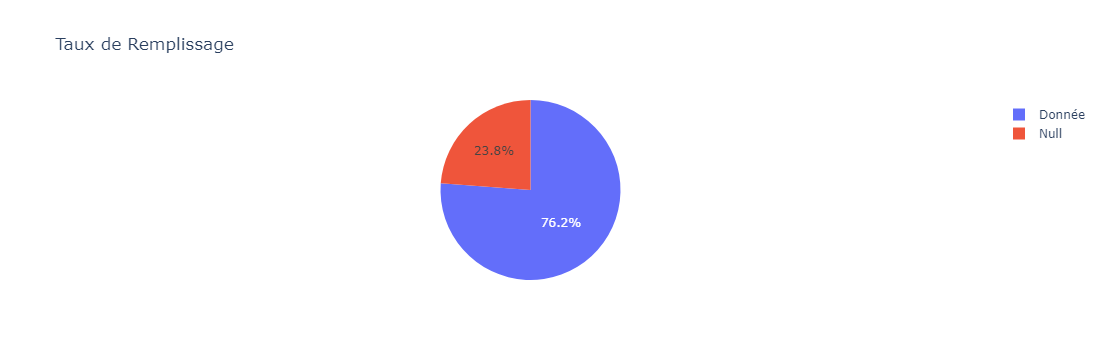

<Figure size 1500x800 with 0 Axes>

In [32]:
Pie_chart2(df_test)

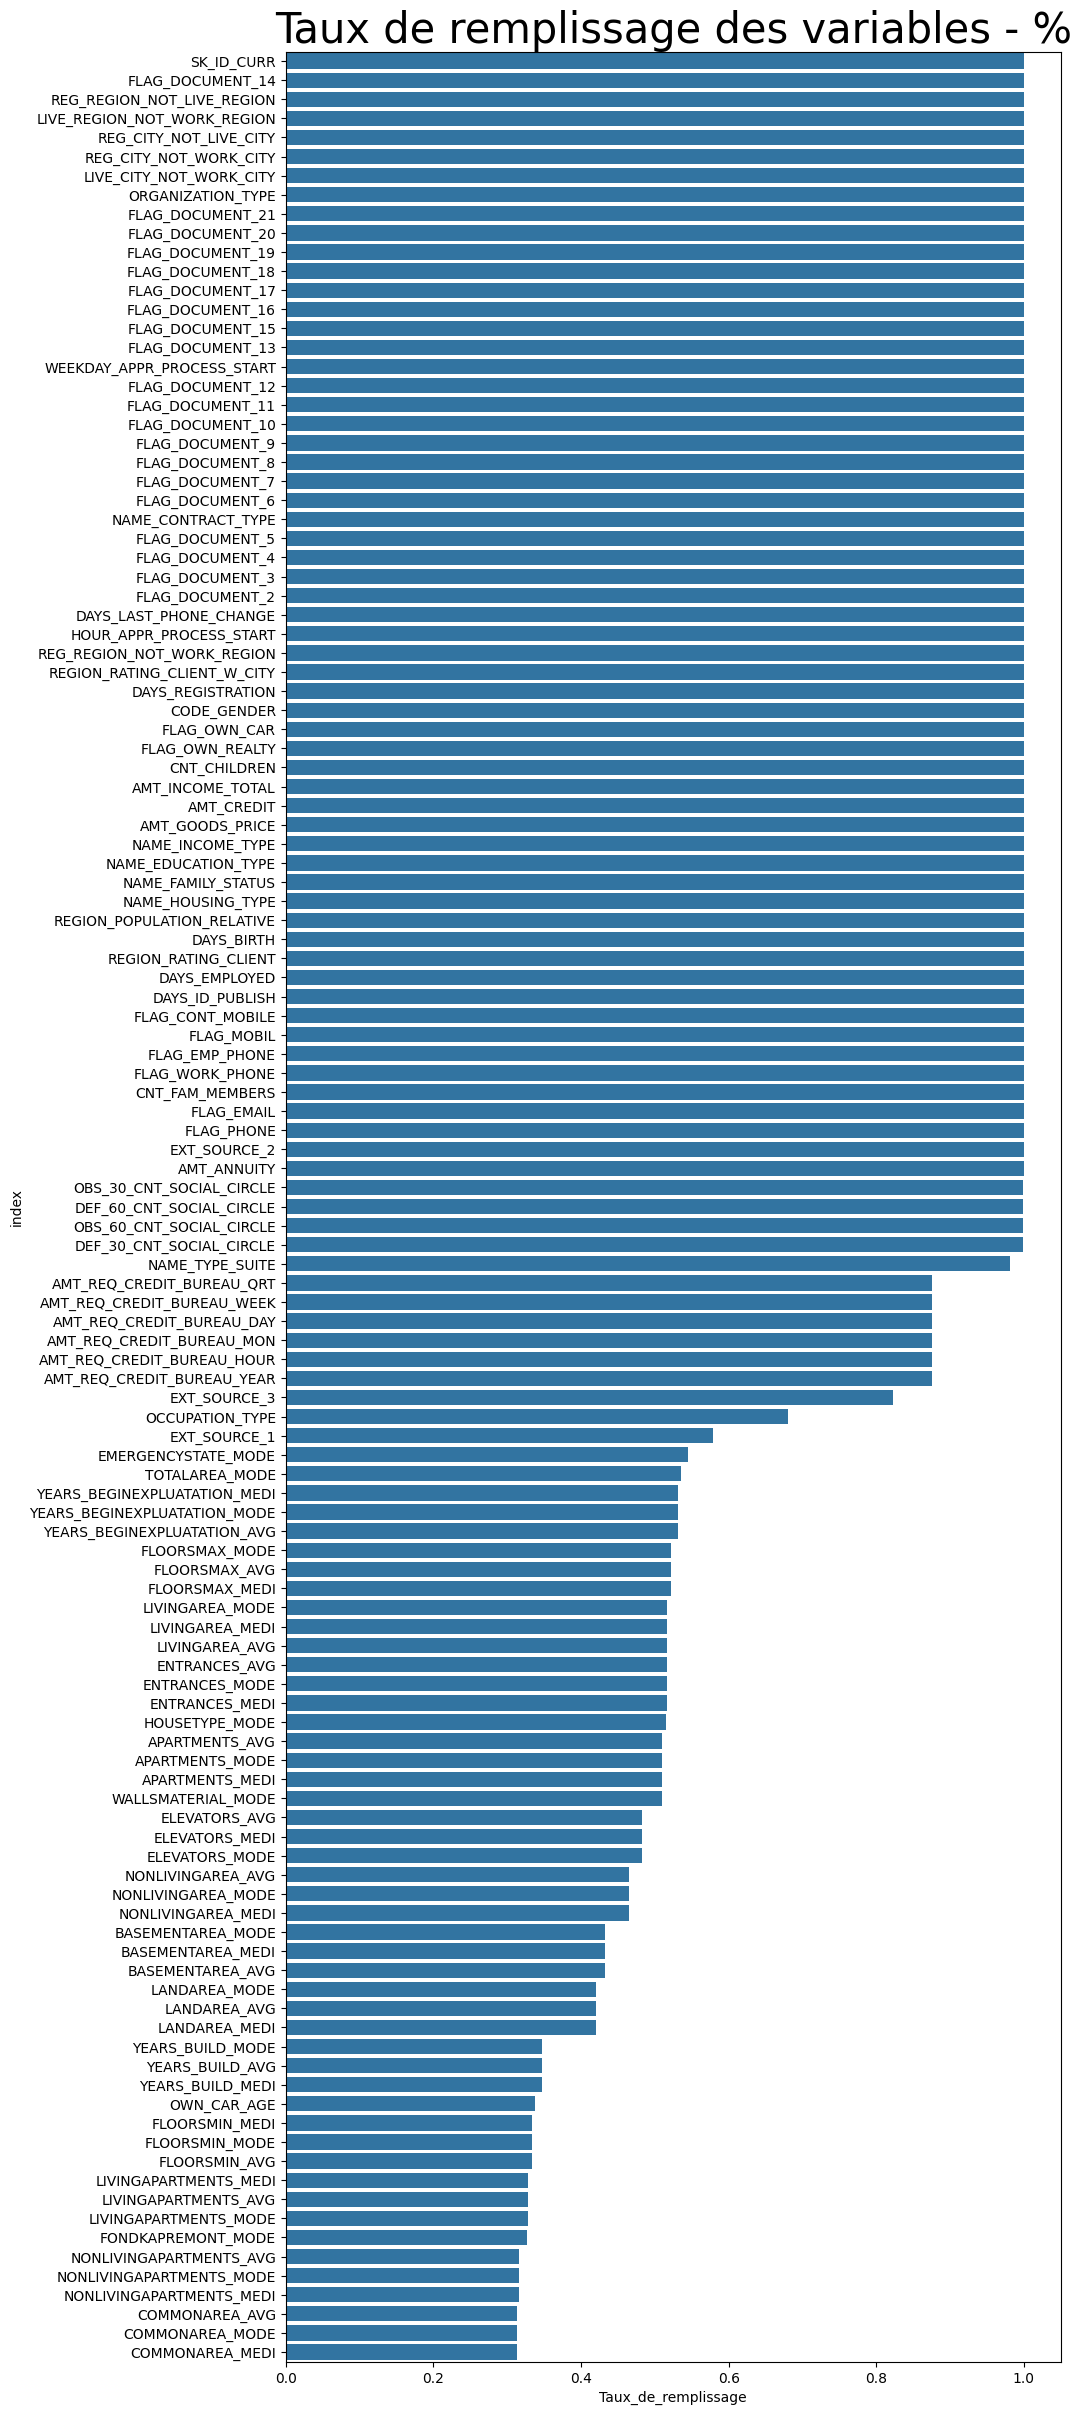

In [34]:
remplissage(df_test)

In [35]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [23]:
df_test.describe()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR
count   48744.000000  48744.000000      4.874400e+04  4.874400e+04   48720.000000     4.874400e+04                48744.000000  48744.000000   48744.000000       48744.000000  ...      48744.000000           48744.0           48744.0           48744.0                42695.000000               42695.000000                42695.000000               42695.000000               42695.000000                42695.000000
mean   277796.676350      0.397054      1.784318e+05  5.167404e+05   29426.240209     4.626188e+05                    0.021226 -16068.084605   67485.366322       -4967.652716  ...          0.001559               0.0               0.0               0.0                    0.002108                   0.001803                    0.002787                   0.009299                   0.546902                    1.983769
std    103169.547296      0.709047      1.015226e+05  3.653970e+05   16016.368315     3.367102e+05                    0.014428   4325.900393  144348.507136        3552.612035  ...          0.039456               0.0               0.0               0.0                    0.046373                   0.046132                    0.054037                   0.110924                   0.693305                    1.838873
min    100001.000000      0.000000      2.694150e+04  4.500000e+04    2295.000000     4.500000e+04                    0.000253 -25195.000000  -17463.000000      -23722.000000  ...          0.000000               0.0               0.0               0.0                    0.000000                   0.000000                    0.000000                   0.000000                   0.000000                    0.000000
25%    188557.750000      0.000000      1.125000e+05  2.606400e+05   17973.000000     2.250000e+05                    0.010006 -19637.000000   -2910.000000       -7459.250000  ...          0.000000               0.0               0.0               0.0                    0.000000                   0.000000                    0.000000                   0.000000                   0.000000                    0.000000
50%    277549.000000      0.000000      1.575000e+05  4.500000e+05   26199.000000     3.960000e+05                    0.018850 -15785.000000   -1293.000000       -4490.000000  ...          0.000000               0.0               0.0               0.0                    0.000000                   0.000000                    0.000000                   0.000000                   0.000000                    2.000000
75%    367555.500000      1.000000      2.250000e+05  6.750000e+05   37390.500000     6.300000e+05                    0.028663 -12496.000000    -296.000000       -1901.000000  ...          0.000000               0.0               0.0               0.0                    0.000000                   0.000000                    0.000000                   0.000000                   1.000000                    3.000000
max    456250.000000     20.000000      4.410000e+06  2.245500e+06  180576.000000     2.245500e+06                    0.072508  -7338.000000  365243.000000           0.000000  ...          1.000000               0.0               0.0               0.0                    2.000000                   2.000000                    2.000000                   6.000000                   7.000000                   17.000000

[8 rows x 105 columns]

## POS_CASH_balance.csv

<ul>
    <li>
        Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    </li>
    <li>
        This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample
    </li>
</ul>

In [39]:
df_home_credit[df_home_credit['Table'] == 'POS_CASH_balance.csv']

Unnamed: 0                 Table                    Row                                                                                                                                                                                                                                                     Description                                Special
142         145  POS_CASH_balance.csv            SK_ID_PREV                                                                                                                ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)                                    NaN
143         146  POS_CASH_balance.csv             SK_ID_CURR                                                                                                                                                                                                                                        ID of loan in our sample                                    NaN
144         147  POS_CASH_balance.csv         MONTHS_BALANCE  Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )  time only relative to the application
145         148  POS_CASH_balance.csv         CNT_INSTALMENT                                                                                                                                                                                                                  Term of previous credit (can change over time)                                    NaN
146         149  POS_CASH_balance.csv  CNT_INSTALMENT_FUTURE                                                                                                                                                                                                                 Installments left to pay on the previous credit                                    NaN
147         150  POS_CASH_balance.csv   NAME_CONTRACT_STATUS                                                                                                                                                                                                                                Contract status during the month                                    NaN
148         151  POS_CASH_balance.csv                 SK_DPD                                                                                                                                                                                                         DPD (days past due) during the month of previous credit                                    NaN
149         152  POS_CASH_balance.csv             SK_DPD_DEF                                                                                                                                                            DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit                                    NaN

In [40]:
df_pos_cash = pd.read_csv(path+'/POS_CASH_balance.csv',)
df_pos_cash = df_pos_cash.loc[:, ~df_pos_cash.columns.str.match('Unnamed')]
df_pos_cash.head(10)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF
0     1803195      182943             -31            48.0                   45.0               Active       0           0
1     1715348      367990             -33            36.0                   35.0               Active       0           0
2     1784872      397406             -32            12.0                    9.0               Active       0           0
3     1903291      269225             -35            48.0                   42.0               Active       0           0
4     2341044      334279             -35            36.0                   35.0               Active       0           0
5     2207092      342166             -32            12.0                   12.0               Active       0           0
6     1110516      204376             -38            48.0                   43.0               Active       0           0
7     1387235      153211             -35            36.0                   36.0               Active       0           0
8     1220500      112740             -31            12.0                   12.0               Active       0           0
9     2371489      274851             -32            24.0                   16.0               Active       0           0

In [41]:
df_pos_cash.shape

(10001358, 8)

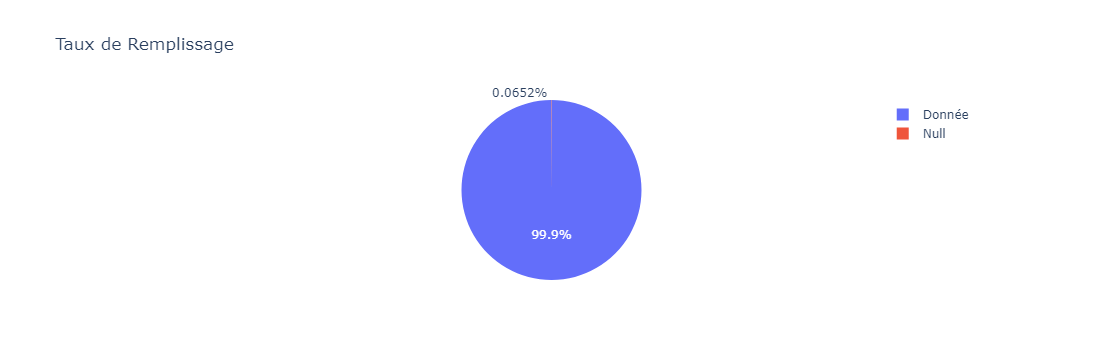

<Figure size 1500x800 with 0 Axes>

In [42]:
Pie_chart2(df_pos_cash)

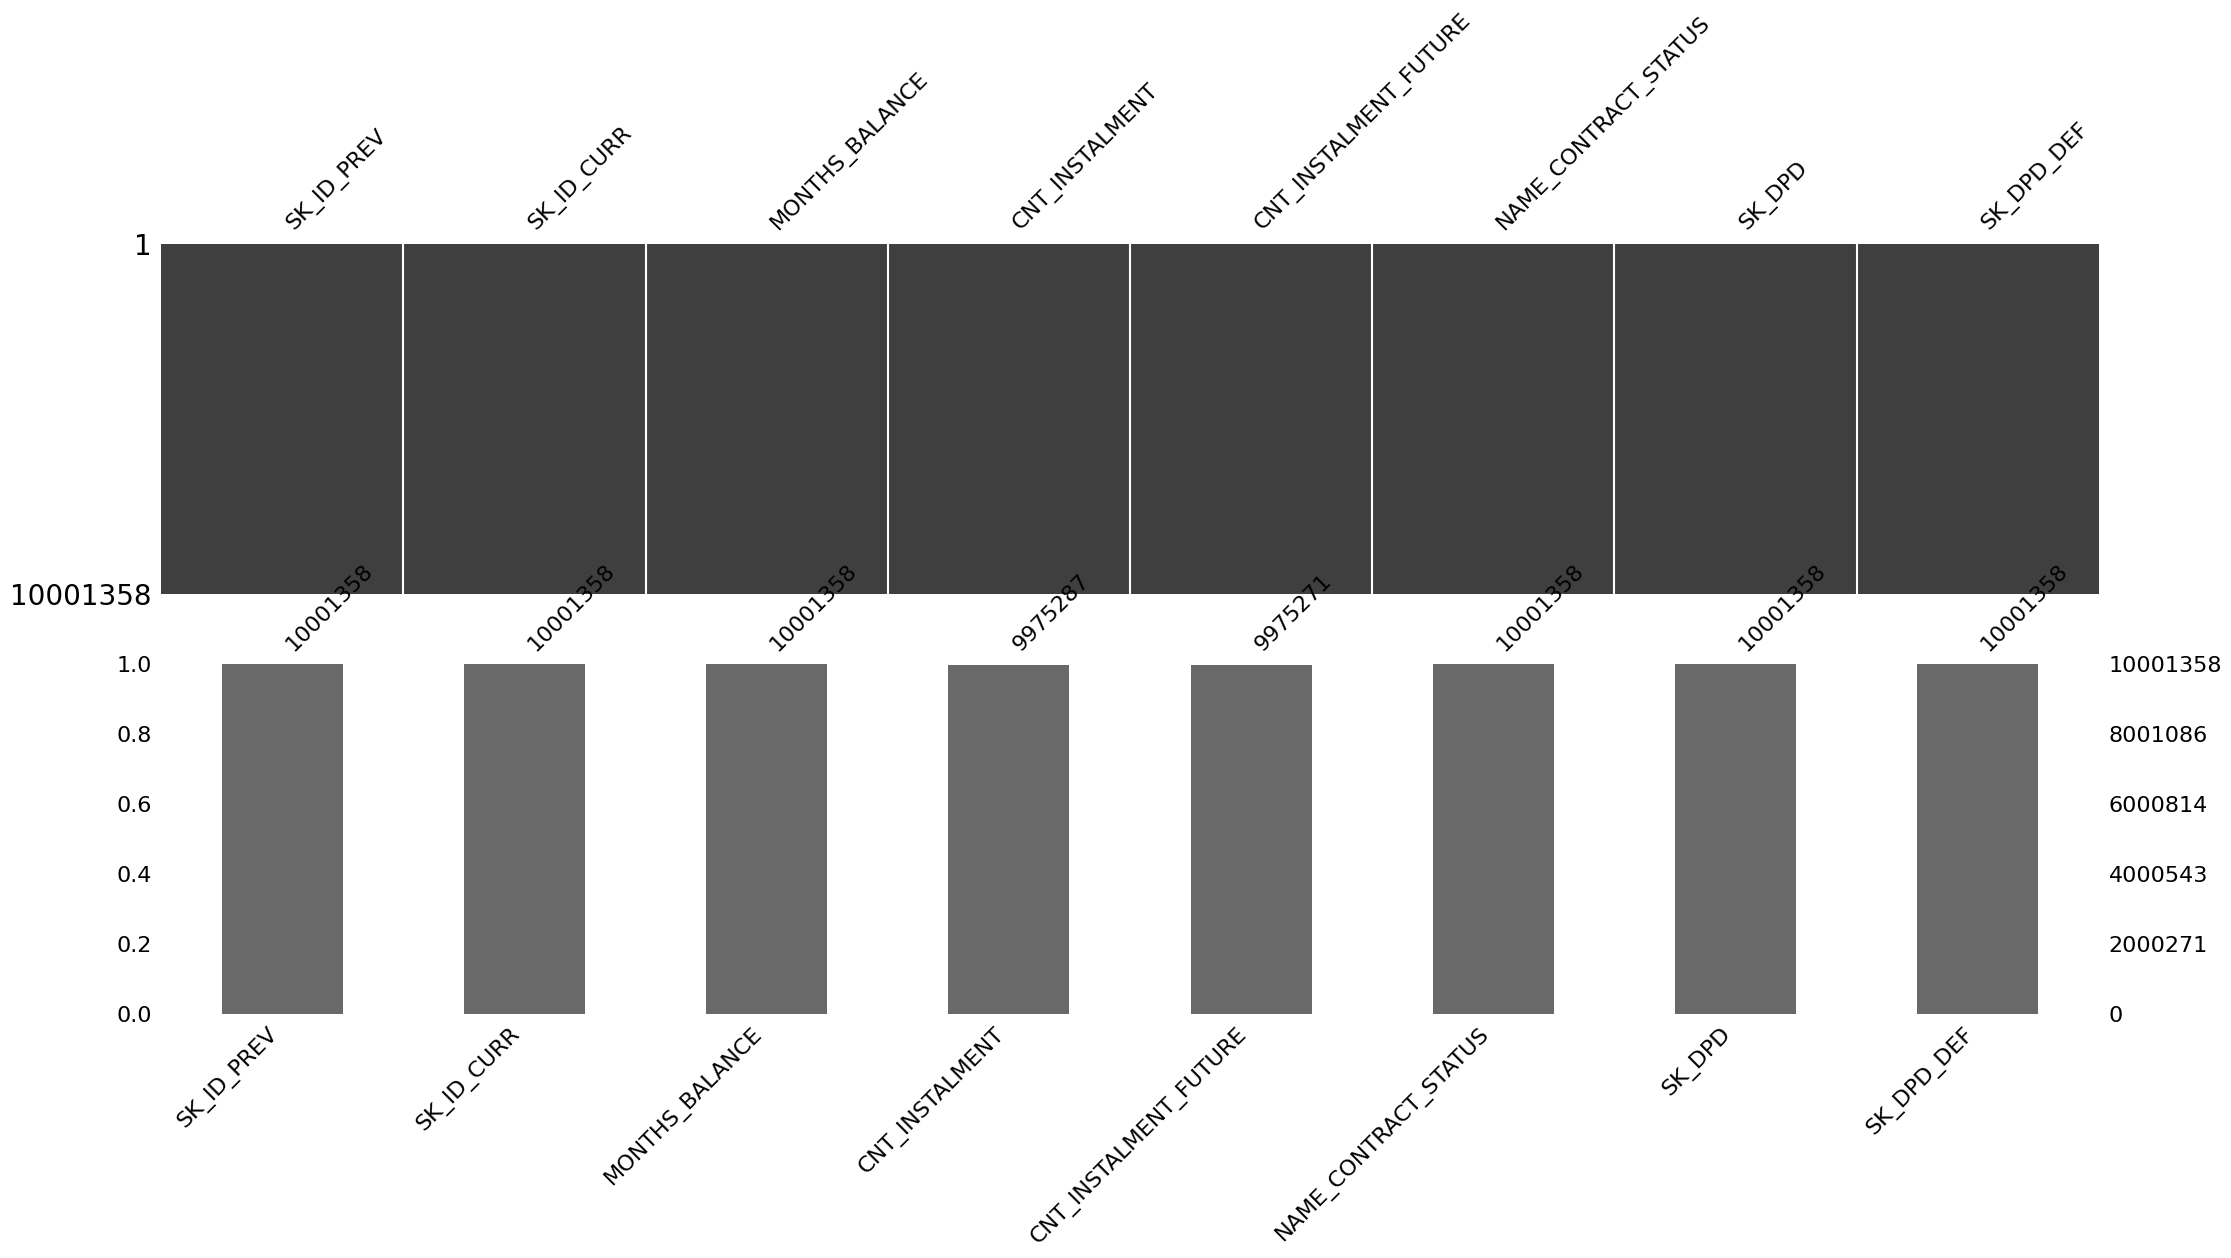

In [43]:
nan_control(df_pos_cash)

In [44]:
df_pos_cash.describe(include = 'all')

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS        SK_DPD    SK_DPD_DEF
count   1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06           9.975271e+06             10001358  1.000136e+07  1.000136e+07
unique           NaN           NaN             NaN             NaN                    NaN                    9           NaN           NaN
top              NaN           NaN             NaN             NaN                    NaN               Active           NaN           NaN
freq             NaN           NaN             NaN             NaN                    NaN              9151119           NaN           NaN
mean    1.903217e+06  2.784039e+05   -3.501259e+01    1.708965e+01           1.048384e+01                  NaN  1.160693e+01  6.544684e-01
std     5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01           1.110906e+01                  NaN  1.327140e+02  3.276249e+01
min     1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00           0.000000e+00                  NaN  0.000000e+00  0.000000e+00
25%     1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01           3.000000e+00                  NaN  0.000000e+00  0.000000e+00
50%     1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01           7.000000e+00                  NaN  0.000000e+00  0.000000e+00
75%     2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01           1.400000e+01                  NaN  0.000000e+00  0.000000e+00
max     2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01           8.500000e+01                  NaN  4.231000e+03  3.595000e+03

In [45]:
df_pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


## credit_card_balance.csv

<ul>
    <li>
        Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    </li>
    <li>
        This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample
    </li>
</ul>

In [46]:
df_home_credit[df_home_credit['Table'] == 'credit_card_balance.csv']

Unnamed: 0                    Table                         Row                                                                                                                                        Description                                Special
150         153  credit_card_balance.csv                 SK_ID_PREV   ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)                                 hashed
151         154  credit_card_balance.csv                  SK_ID_CURR                                                                                                                           ID of loan in our sample                                 hashed
152         155  credit_card_balance.csv              MONTHS_BALANCE                                                                 Month of balance relative to application date (-1 means the freshest balance date)  time only relative to the application
153         156  credit_card_balance.csv                 AMT_BALANCE                                                                                                        Balance during the month of previous credit                                    NaN
154         157  credit_card_balance.csv     AMT_CREDIT_LIMIT_ACTUAL                                                                                          Credit card limit during the month of the previous credit                                    NaN
155         158  credit_card_balance.csv    AMT_DRAWINGS_ATM_CURRENT                                                                                      Amount drawing at ATM during the month of the previous credit                                    NaN
156         159  credit_card_balance.csv        AMT_DRAWINGS_CURRENT                                                                                             Amount drawing during the month of the previous credit                                    NaN
157         160  credit_card_balance.csv  AMT_DRAWINGS_OTHER_CURRENT                                                                                   Amount of other drawings during the month of the previous credit                                    NaN
158         161  credit_card_balance.csv    AMT_DRAWINGS_POS_CURRENT                                                                             Amount drawing or buying goods during the month of the previous credit                                    NaN
159         162  credit_card_balance.csv     AMT_INST_MIN_REGULARITY                                                                                          Minimal installment for this month of the previous credit                                    NaN
160         163  credit_card_balance.csv         AMT_PAYMENT_CURRENT                                                                                How much did the client pay during the month on the previous credit                                    NaN
161         164  credit_card_balance.csv   AMT_PAYMENT_TOTAL_CURRENT                                                                       How much did the client pay during the month in total on the previous credit                                    NaN
162         165  credit_card_balance.csv    AMT_RECEIVABLE_PRINCIPAL                                                                                             Amount receivable for principal on the previous credit                                    NaN
163         166  credit_card_balance.csv               AMT_RECIVABLE                                                                                                           Amount receivable on the previous credit                                    NaN
164         167  credit_card_balance.csv        AMT_TOTAL_RECEIVABLE                                                                                                     Total amoun

In [48]:
df_card_balance = pd.read_csv(path+'/credit_card_balance.csv',)
df_card_balance = df_card_balance.loc[:, ~df_card_balance.columns.str.match('Unnamed')]
df_card_balance.head(10)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF
0     2562384      378907              -6       56.970                   135000                       0.0               877.500                         0.0                   877.500                 1700.325  ...          0.000                 0.000                       0.0                     1                         0.0                       1.0                       35.0                Active       0           0
1     2582071      363914              -1    63975.555                    45000                    2250.0              2250.000                         0.0                     0.000                 2250.000  ...      64875.555             64875.555                       1.0                     1                         0.0                       0.0                       69.0                Active       0           0
2     1740877      371185              -7    31815.225                   450000                       0.0                 0.000                         0.0                     0.000                 2250.000  ...      31460.085             31460.085                       0.0                     0                         0.0                       0.0                       30.0                Active       0           0
3     1389973      337855              -4   236572.110                   225000                    2250.0              2250.000                         0.0                     0.000                11795.760  ...     233048.970            233048.970                       1.0                     1                         0.0                       0.0                       10.0                Active       0           0
4     1891521      126868              -1   453919.455                   450000                       0.0             11547.000                         0.0                 11547.000                22924.890  ...     453919.455            453919.455                       0.0                     1                         0.0                       1.0                      101.0                Active       0           0
5     2646502      380010              -7    82903.815                   270000                       0.0                 0.000                         0.0                     0.000                 4449.105  ...      82773.315             82773.315                       0.0                     0                         0.0                       0.0                        2.0                Active       7           0
6     1079071      171320              -6   353451.645                   585000                   67500.0             67500.000                         0.0                     0.000                14684.175  ...     351881.145            351881.145                       1.0                     1                         0.0                       0.0                        6.0                Active       0           0
7     2095912      118650              -7    47962.125                    45000                   45000.0             45000.000                         0.0                     0.000                    0.000  ...      47962.125             47962.125                       1.0                     1                         0.0                       0.0                       51.0                Active       0           0
8     2181852      367360              -4   291543.075                   292500                   90000.0            289339.425                         0.0                199339.425                  130.500  ...     286831.

In [49]:
df_card_balance.shape

(3840312, 23)

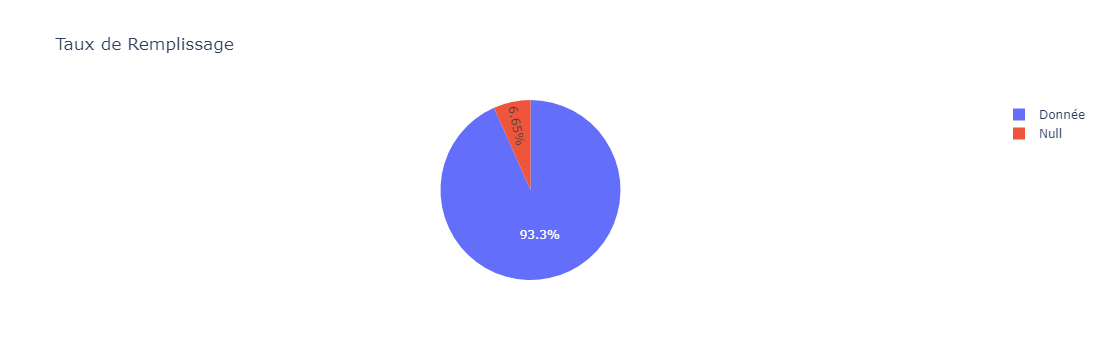

<Figure size 1500x800 with 0 Axes>

In [50]:
Pie_chart2(df_card_balance)

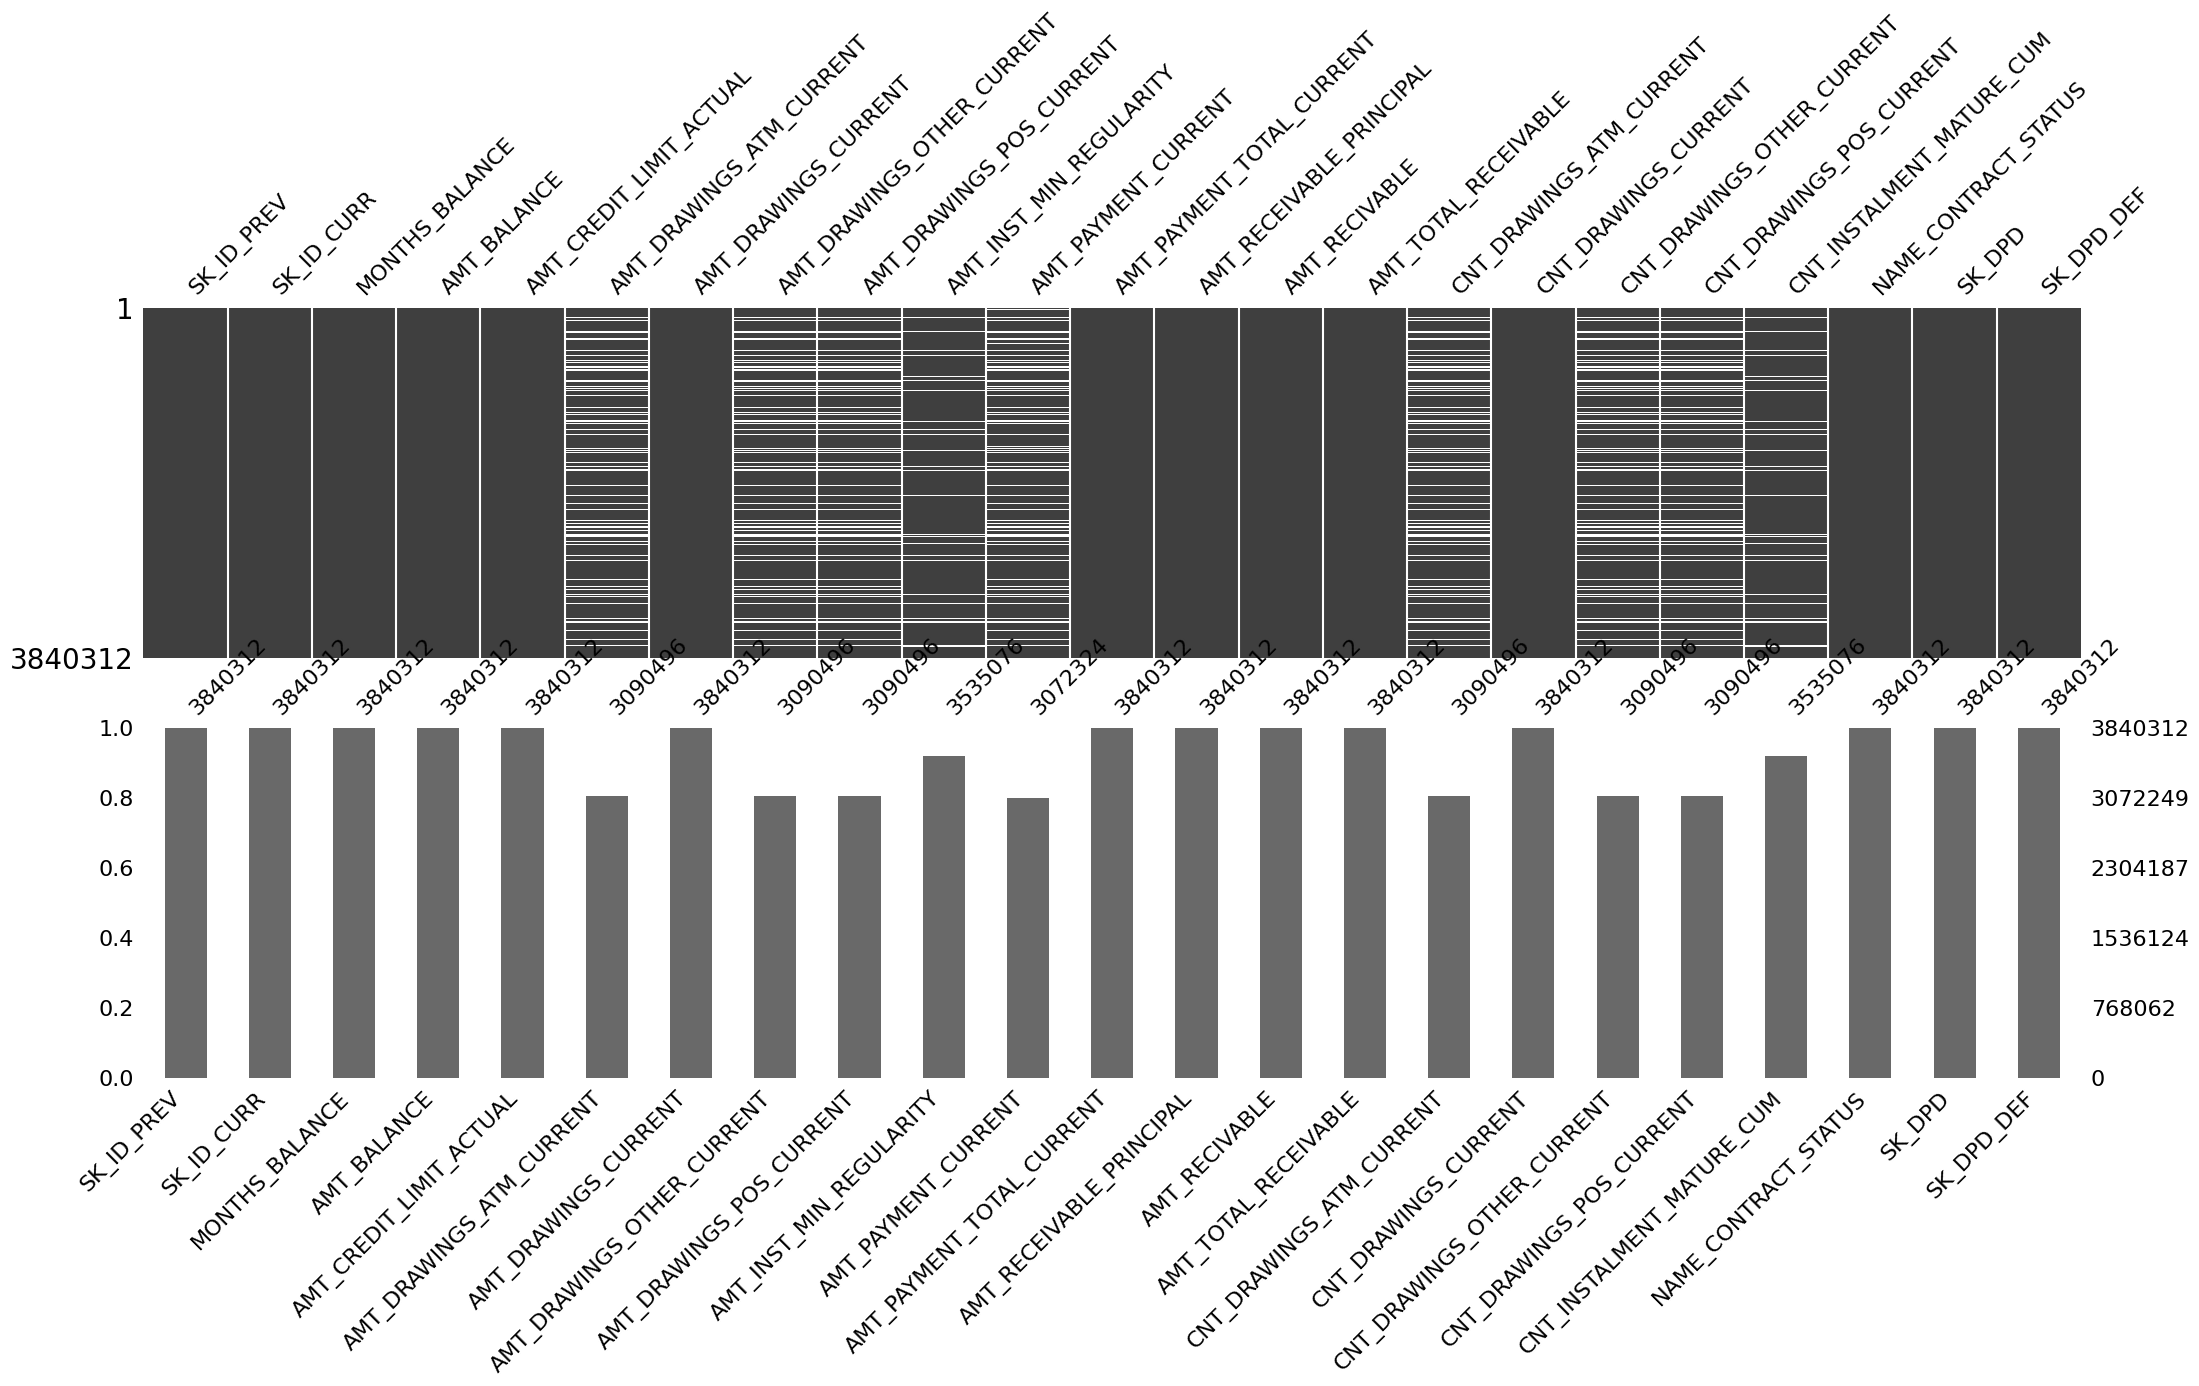

In [51]:
nan_control(df_card_balance)

In [52]:
df_card_balance.describe(include = 'all')

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS        SK_DPD    SK_DPD_DEF
count   3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06             3.840312e+06              3.090496e+06          3.840312e+06                3.090496e+06              3.090496e+06             3.535076e+06  ...   3.840312e+06          3.840312e+06              3.090496e+06          3.840312e+06                3.090496e+06              3.090496e+06               3.535076e+06               3840312  3.840312e+06  3.840312e+06
unique           NaN           NaN             NaN           NaN                      NaN                       NaN                   NaN                         NaN                       NaN                      NaN  ...            NaN                   NaN                       NaN                   NaN                         NaN                       NaN                        NaN                     7           NaN           NaN
top              NaN           NaN             NaN           NaN                      NaN                       NaN                   NaN                         NaN                       NaN                      NaN  ...            NaN                   NaN                       NaN                   NaN                         NaN                       NaN                        NaN                Active           NaN           NaN
freq             NaN           NaN             NaN           NaN                      NaN                       NaN                   NaN                         NaN                       NaN                      NaN  ...            NaN                   NaN                       NaN                   NaN                         NaN                       NaN                        NaN               3698436           NaN           NaN
mean    1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04             1.538080e+05              5.961325e+03          7.433388e+03                2.881696e+02              2.968805e+03             3.540204e+03  ...   5.808881e+04          5.809829e+04              3.094490e-01          7.031439e-01                4.812496e-03              5.594791e-01               2.082508e+01                   NaN  9.283667e+00  3.316220e-01
std     5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05             1.651457e+05              2.822569e+04          3.384608e+04                8.201989e+03              2.079689e+04             5.600154e+03  ...   1.059654e+05          1.059718e+05              1.100401e+00          3.190347e+00                8.263861e-02              3.240649e+00               2.005149e+01                   NaN  9.751570e+01  2.147923e+01
min     1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05             0.000000e+00             -6.827310e+03         -6.211620e+03                0.000000e+00              0.000000e+00             0.000000e+00  ...  -4.202502e+05         -4.202502e+05              0.000000e+00          0.000000e+00                0.000000e+00              0.000000e+00               0.000000e+00                   NaN  0.000000e+00  0.000000e+00
25%     1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00             4.500000e+04              0.000000e+00          0.000000e+00                0.000000e+00              0.000000e+00             0.000000e+00  ...   0.000000e+00          0.000000e+00              0.000000e+00          0.000000e+00                0.000000e+00              0.000000e+00               4.000000e+00                   NaN  0.000000e+00  0.000000e+00
50%     1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00    

In [53]:
df_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

## installments_payments.csv

<ul>
    <li>
        Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    </li>
    <li>
        There is a) one row for every payment that was made plus b) one row each for missed payment.
    </li>
    <li>
        One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
    </li>
</ul>

In [54]:
df_home_credit[df_home_credit['Table'] == 'installments_payments.csv']

Unnamed: 0                      Table                     Row                                                                                                                                                                                 Description                                Special
211         214  installments_payments.csv             SK_ID_PREV                                            ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)                                 hashed
212         215  installments_payments.csv              SK_ID_CURR                                                                                                                                                                    ID of loan in our sample                                 hashed
213         216  installments_payments.csv  NUM_INSTALMENT_VERSION  Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed                                    NaN
214         217  installments_payments.csv   NUM_INSTALMENT_NUMBER                                                                                                                                                     On which installment we observe payment                                    NaN
215         218  installments_payments.csv         DAYS_INSTALMENT                                                                              When the installment of previous credit was supposed to be paid (relative to application date of current loan)  time only relative to the application
216         219  installments_payments.csv      DAYS_ENTRY_PAYMENT                                                                                   When was the installments of previous credit paid actually (relative to application date of current loan)  time only relative to the application
217         220  installments_payments.csv          AMT_INSTALMENT                                                                                                           What was the prescribed installment amount of previous credit on this installment                                    NaN
218         221  installments_payments.csv             AMT_PAYMENT                                                                                                                        What the client actually paid on previous credit on this installment                                    NaN

In [55]:
df_inst_pay = pd.read_csv(path+'/installments_payments.csv',)
df_inst_pay= df_inst_pay.loc[:, ~df_inst_pay.columns.str.match('Unnamed')]
df_inst_pay.head(10)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT
0     1054186      161674                     1.0                      6          -1180.0             -1187.0        6948.360     6948.360
1     1330831      151639                     0.0                     34          -2156.0             -2156.0        1716.525     1716.525
2     2085231      193053                     2.0                      1            -63.0               -63.0       25425.000    25425.000
3     2452527      199697                     1.0                      3          -2418.0             -2426.0       24350.130    24350.130
4     2714724      167756                     1.0                      2          -1383.0             -1366.0        2165.040     2160.585
5     1137312      164489                     1.0                     12          -1384.0             -1417.0        5970.375     5970.375
6     2234264      184693                     4.0                     11           -349.0              -352.0       29432.295    29432.295
7     1818599      111420                     2.0                      4           -968.0              -994.0       17862.165    17862.165
8     2723183      112102                     0.0                     14           -197.0              -197.0          70.740       70.740
9     1413990      109741                     1.0                      4           -570.0              -609.0       14308.470    14308.470

In [56]:
df_inst_pay.shape

(13605401, 8)

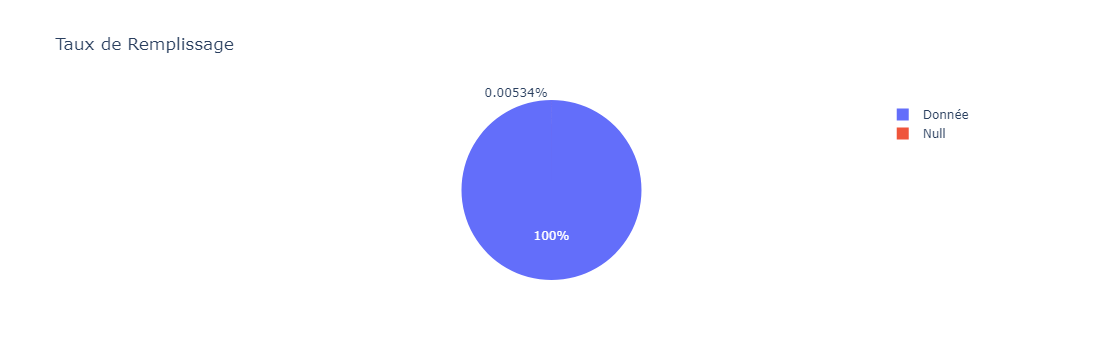

<Figure size 1500x800 with 0 Axes>

In [57]:
Pie_chart2(df_inst_pay)

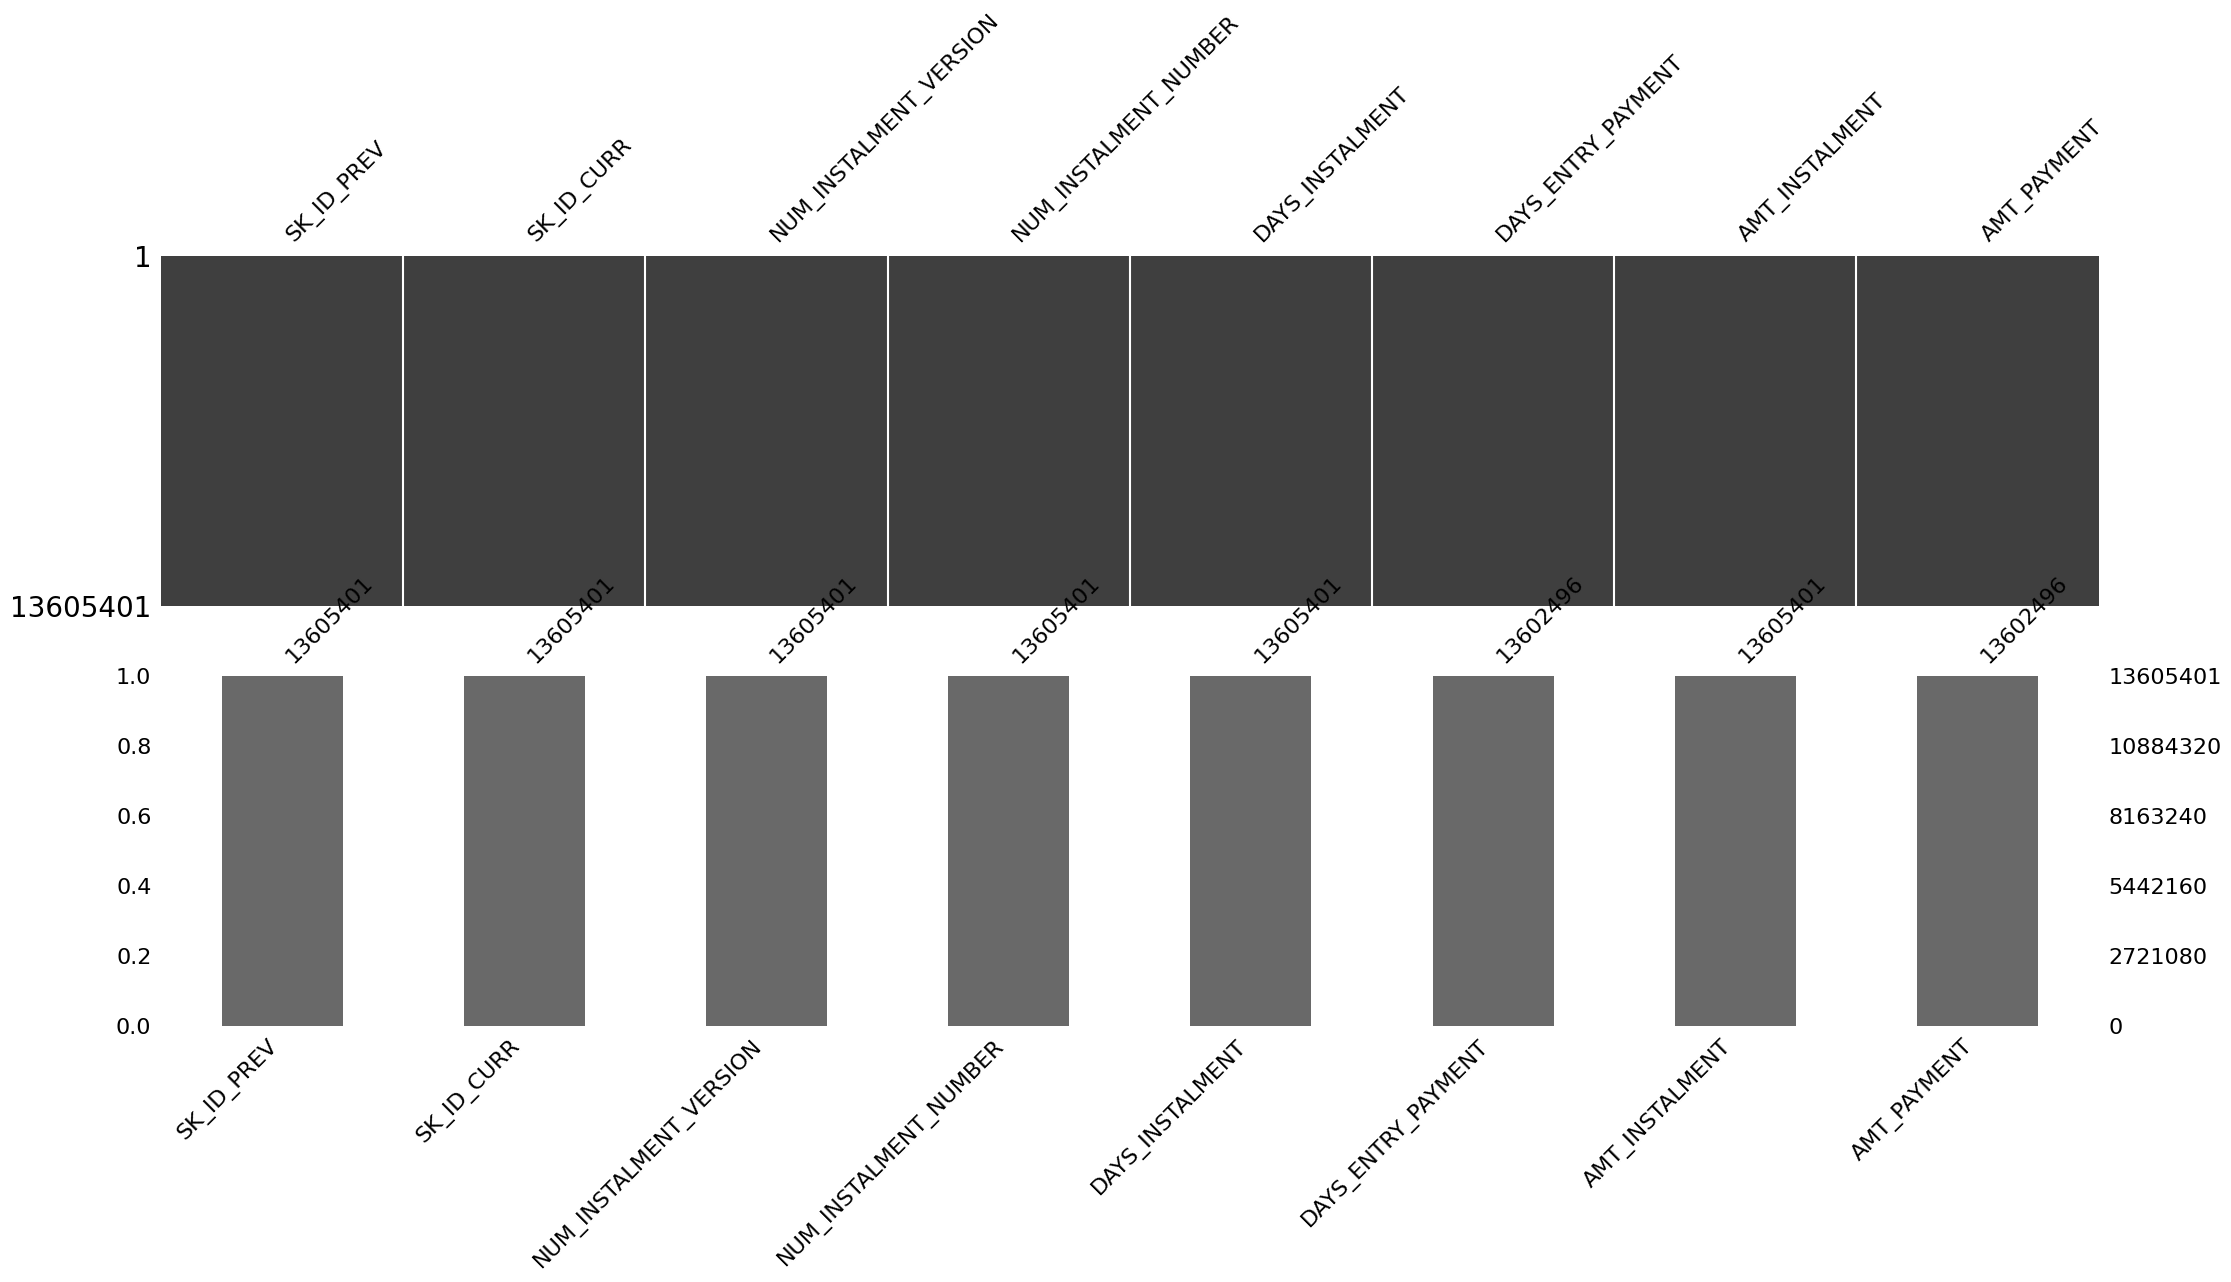

In [58]:
nan_control(df_inst_pay)

In [59]:
df_inst_pay.describe(include = 'all')

SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT
count  1.360540e+07  1.360540e+07            1.360540e+07           1.360540e+07     1.360540e+07        1.360250e+07    1.360540e+07  1.360250e+07
mean   1.903365e+06  2.784449e+05            8.566373e-01           1.887090e+01    -1.042270e+03       -1.051114e+03    1.705091e+04  1.723822e+04
std    5.362029e+05  1.027183e+05            1.035216e+00           2.666407e+01     8.009463e+02        8.005859e+02    5.057025e+04  5.473578e+04
min    1.000001e+06  1.000010e+05            0.000000e+00           1.000000e+00    -2.922000e+03       -4.921000e+03    0.000000e+00  0.000000e+00
25%    1.434191e+06  1.896390e+05            0.000000e+00           4.000000e+00    -1.654000e+03       -1.662000e+03    4.226085e+03  3.398265e+03
50%    1.896520e+06  2.786850e+05            1.000000e+00           8.000000e+00    -8.180000e+02       -8.270000e+02    8.884080e+03  8.125515e+03
75%    2.369094e+06  3.675300e+05            1.000000e+00           1.900000e+01    -3.610000e+02       -3.700000e+02    1.671021e+04  1.610842e+04
max    2.843499e+06  4.562550e+05            1.780000e+02           2.770000e+02    -1.000000e+00       -1.000000e+00    3.771488e+06  3.771488e+06

In [60]:
df_inst_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


## bureau.csv

<ul>
    <li>All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). </li>
    <li>For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.</li>
</ul>

In [61]:
df_home_credit[df_home_credit['Table'] == 'bureau.csv']

Unnamed: 0       Table                     Row                                                                                                          Description                                Special
122         125  bureau.csv              SK_ID_CURR  ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau                                  hashed
123         126  bureau.csv            SK_BUREAU_ID            Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)                                 hashed
124         127  bureau.csv           CREDIT_ACTIVE                                                                    Status of the Credit Bureau (CB) reported credits                                    NaN
125         128  bureau.csv         CREDIT_CURRENCY                                                                         Recoded currency of the Credit Bureau credit                                recoded
126         129  bureau.csv             DAYS_CREDIT                                   How many days before current application did client apply for Credit Bureau credit  time only relative to the application
127         130  bureau.csv      CREDIT_DAY_OVERDUE                       Number of days past due on CB credit at the time of application for related loan in our sample                                    NaN
128         131  bureau.csv     DAYS_CREDIT_ENDDATE                                  Remaining duration of CB credit (in days) at the time of application in Home Credit  time only relative to the application
129         132  bureau.csv       DAYS_ENDDATE_FACT                        Days since CB credit ended at the time of application in Home Credit (only for closed credit)  time only relative to the application
130         133  bureau.csv  AMT_CREDIT_MAX_OVERDUE                Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)                                    NaN
131         134  bureau.csv      CNT_CREDIT_PROLONG                                                                How many times was the Credit Bureau credit prolonged                                    NaN
132         135  bureau.csv          AMT_CREDIT_SUM                                                                   Current credit amount for the Credit Bureau credit                                    NaN
133         136  bureau.csv     AMT_CREDIT_SUM_DEBT                                                                                 Current debt on Credit Bureau credit                                    NaN
134         137  bureau.csv    AMT_CREDIT_SUM_LIMIT                                                        Current credit limit of credit card reported in Credit Bureau                                    NaN
135         138  bureau.csv  AMT_CREDIT_SUM_OVERDUE                                                                       Current amount overdue on Credit Bureau credit                                    NaN
136         139  bureau.csv             CREDIT_TYPE                                                                         Type of Credit Bureau credit (Car, cash,...)                                    NaN
137         140  bureau.csv      DAYS_CREDIT_UPDATE                       How many days before loan application did last information about the Credit Bureau credit come  time only relative to the application
138         141  bureau.csv             AMT_ANNUITY                                                                                  Annuity of the Credit Bureau credit                                    NaN

In [62]:
df_bureau = pd.read_csv(path+'/bureau.csv',)
df_bureau= df_bureau.loc[:, ~df_bureau.columns.str.match('Unnamed')]
df_bureau.tail(3)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY
1716425      100044       5057762        Closed      currency 1        -1809                   0              -1628.0             -970.0                     NaN                   0         15570.0                  NaN                   NaN                     0.0  Consumer credit                -967          NaN
1716426      246829       5057770        Closed      currency 1        -1878                   0              -1513.0            -1513.0                     NaN                   0         36000.0                  0.0                   0.0                     0.0  Consumer credit               -1508          NaN
1716427      246829       5057778        Closed      currency 1         -463                   0                  NaN             -387.0                     NaN                   0         22500.0                  0.0                   NaN                     0.0        Microloan                -387          NaN

In [63]:
df_bureau.shape

(1716428, 17)

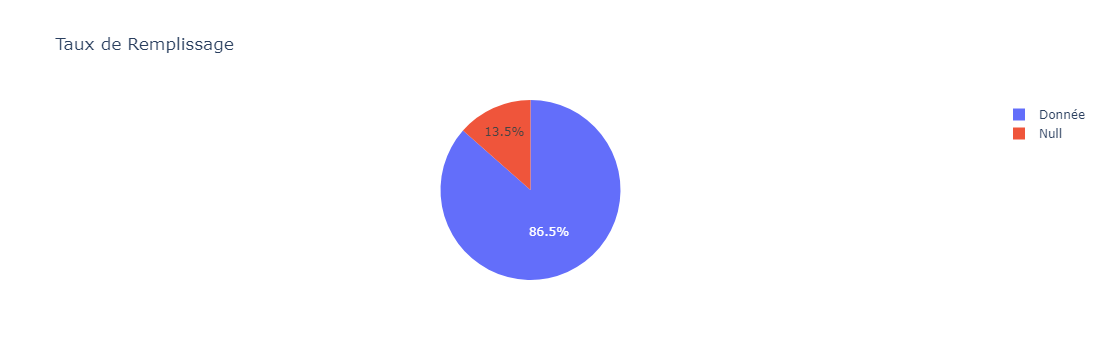

<Figure size 1500x800 with 0 Axes>

In [64]:
Pie_chart2(df_bureau)

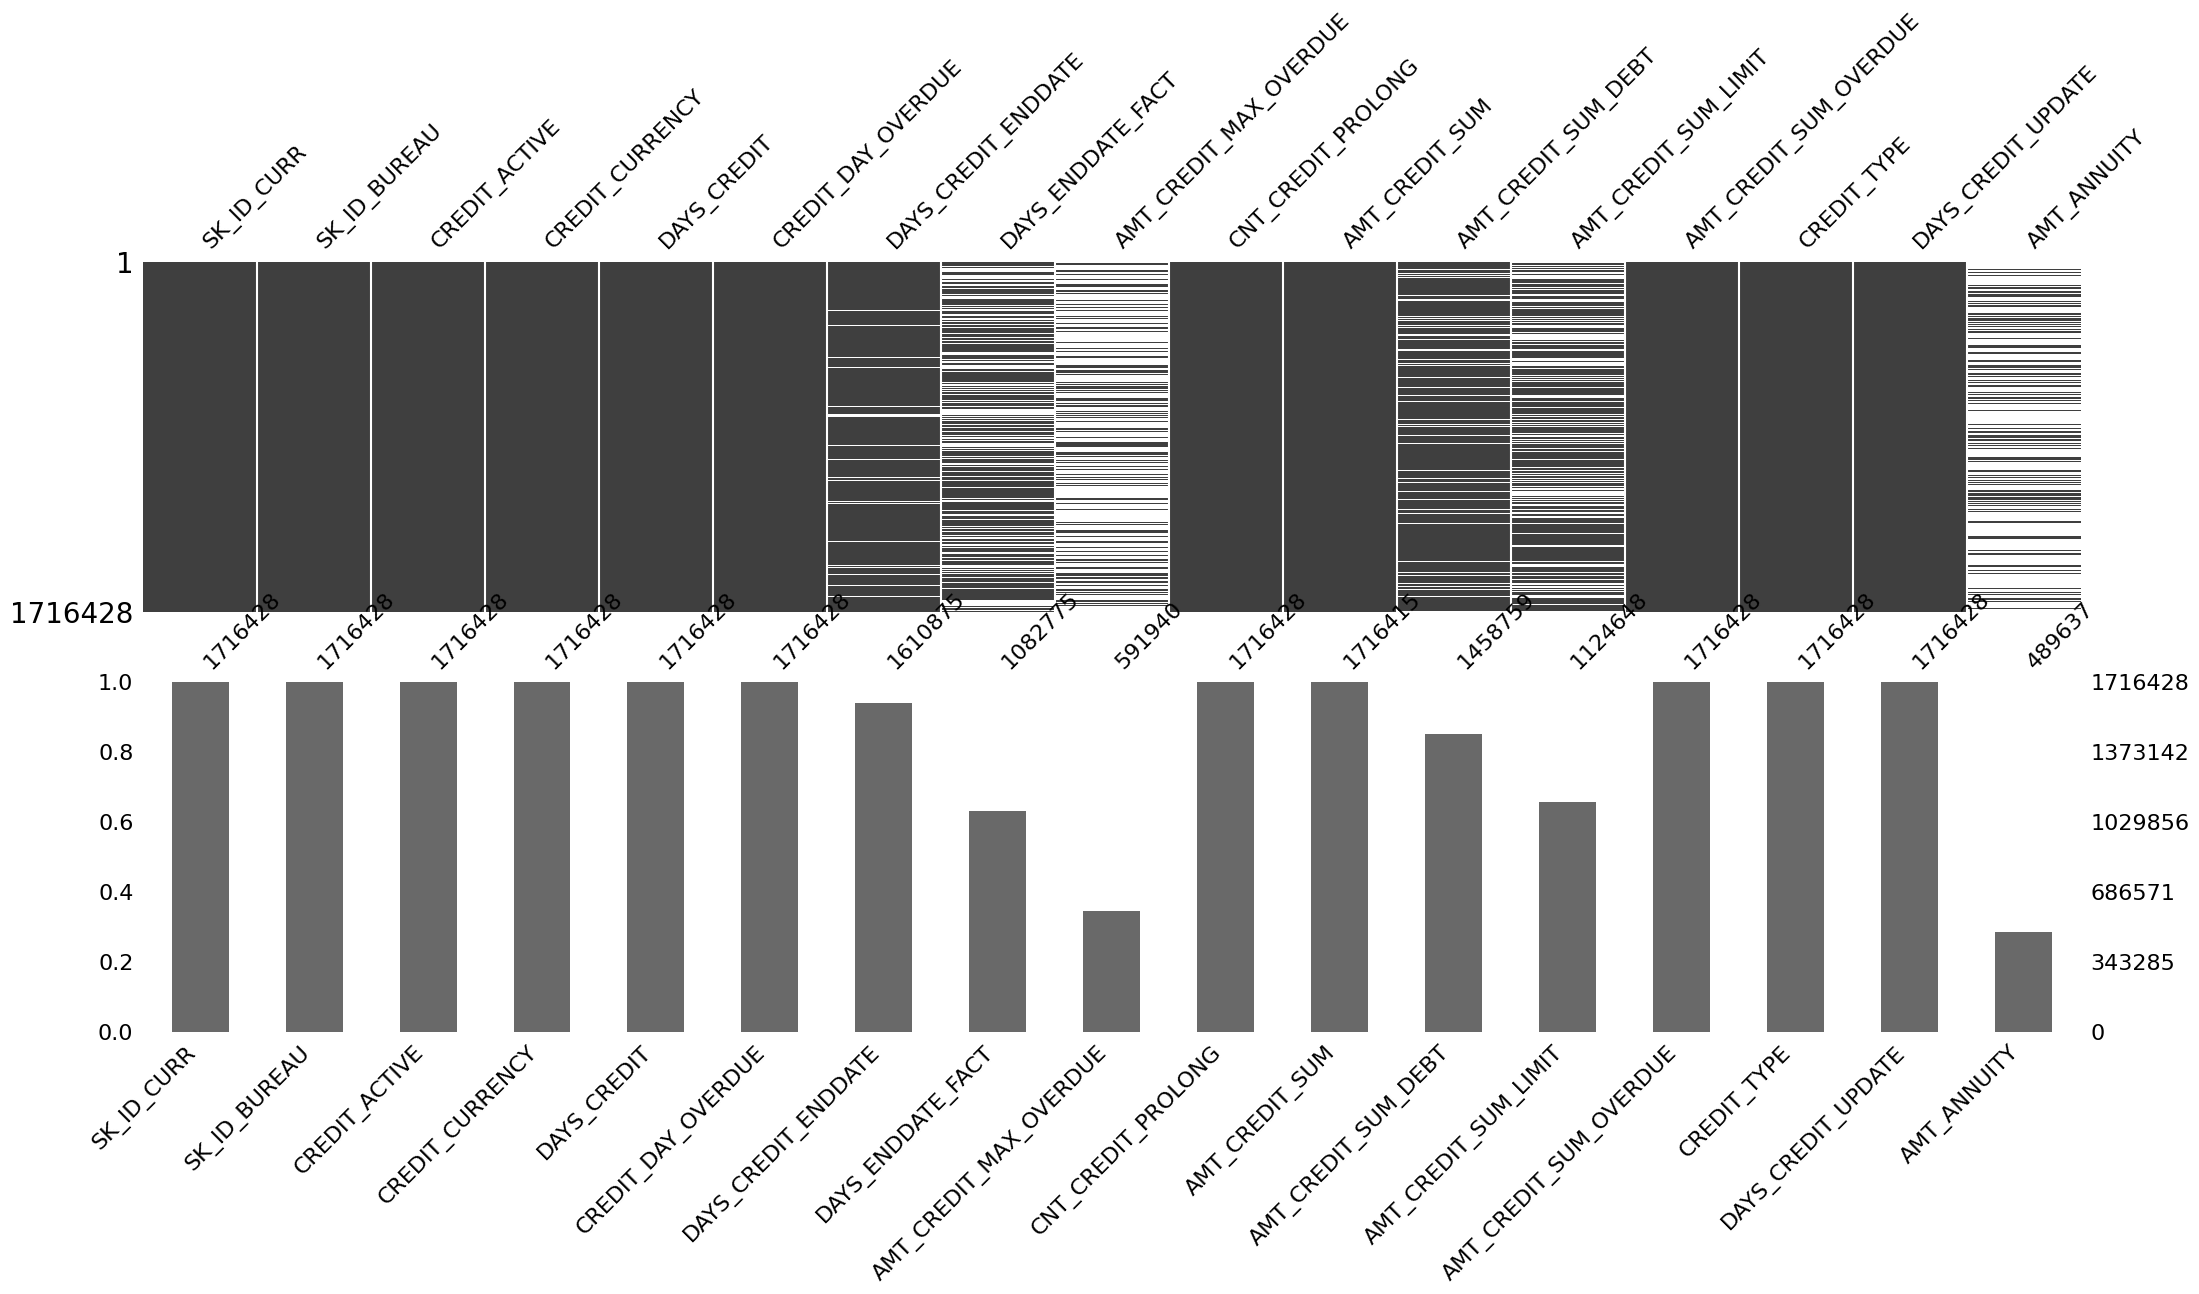

In [65]:
nan_control(df_bureau)

In [66]:
df_bureau.describe()

SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE   AMT_ANNUITY
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06         1.610875e+06       1.082775e+06            5.919400e+05        1.716428e+06    1.716415e+06         1.458759e+06          1.124648e+06            1.716428e+06        1.716428e+06  4.896370e+05
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01         5.105174e+02      -1.017437e+03            3.825418e+03        6.410406e-03    3.549946e+05         1.370851e+05          6.229515e+03            3.791276e+01       -5.937483e+02  1.571276e+04
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01         4.994220e+03       7.140106e+02            2.060316e+05        9.622391e-02    1.149811e+06         6.774011e+05          4.503203e+04            5.937650e+03        7.207473e+02  3.258269e+05
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00        -4.206000e+04      -4.202300e+04            0.000000e+00        0.000000e+00    0.000000e+00        -4.705600e+06         -5.864061e+05            0.000000e+00       -4.194700e+04  0.000000e+00
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00        -1.138000e+03      -1.489000e+03            0.000000e+00        0.000000e+00    5.130000e+04         0.000000e+00          0.000000e+00            0.000000e+00       -9.080000e+02  0.000000e+00
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00        -3.300000e+02      -8.970000e+02            0.000000e+00        0.000000e+00    1.255185e+05         0.000000e+00          0.000000e+00            0.000000e+00       -3.950000e+02  0.000000e+00
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00         4.740000e+02      -4.250000e+02            0.000000e+00        0.000000e+00    3.150000e+05         4.015350e+04          0.000000e+00            0.000000e+00       -3.300000e+01  1.350000e+04
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03         3.119900e+04       0.000000e+00            1.159872e+08        9.000000e+00    5.850000e+08         1.701000e+08          4.705600e+06            3.756681e+06        3.720000e+02  1.184534e+08

In [67]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## bureau_balance.csv

<ul>
    <li>Monthly balances of previous credits in Credit Bureau. </li>
    <li>This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.</li>
</ul>

In [68]:
df_home_credit[df_home_credit['Table'] == 'bureau_balance.csv']

Unnamed: 0               Table             Row                                                                                                                                                                                                                                       Description                                Special
139         142  bureau_balance.csv    SK_BUREAU_ID                                                                                                                                Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table                                  hashed
140         143  bureau_balance.csv  MONTHS_BALANCE                                                                                                                                                                Month of balance relative to application date (-1 means the freshest balance date)  time only relative to the application
141         144  bureau_balance.csv          STATUS  Status of Credit Bureau loan during the month (active, closed, DPD0-30,
 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,
 5 means DPD 120+ or sold or written off ] )                                    NaN

In [69]:
df_buro_bal = pd.read_csv(path+'/bureau_balance.csv',)
df_buro_bal = df_buro_bal.loc[:, ~df_buro_bal.columns.str.match('Unnamed')]
df_buro_bal.head(10)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C
5       5715448              -5      C
6       5715448              -6      C
7       5715448              -7      C
8       5715448              -8      C
9       5715448              -9      0

In [70]:
df_buro_bal.shape

(27299925, 3)

In [71]:
Pie_chart2(df_buro_bal)

<Figure size 1500x800 with 0 Axes>

In [72]:
nan_control(df_buro_bal)

In [73]:
df_buro_bal.describe(include = 'all')

SK_ID_BUREAU  MONTHS_BALANCE    STATUS
count   2.729992e+07    2.729992e+07  27299925
unique           NaN             NaN         8
top              NaN             NaN         C
freq             NaN             NaN  13646993
mean    6.036297e+06   -3.074169e+01       NaN
std     4.923489e+05    2.386451e+01       NaN
min     5.001709e+06   -9.600000e+01       NaN
25%     5.730933e+06   -4.600000e+01       NaN
50%     6.070821e+06   -2.500000e+01       NaN
75%     6.431951e+06   -1.100000e+01       NaN
max     6.842888e+06    0.000000e+00       NaN

In [74]:
df_buro_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


## previous_application.csv

<ul>
    <li>
        All previous applications for Home Credit loans of clients who have loans in our sample.
    </li>
    <li>
        There is one row for each previous application related to loans in our data sample.
    </li>
</ul>

In [75]:
df_home_credit[df_home_credit['Table'] == 'previous_application.csv']

Unnamed: 0                     Table                          Row                                                                                                                                                                                                                                                          Description                                Special
173         176  previous_application.csv                  SK_ID_PREV                                ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit)                                  hashed
174         177  previous_application.csv                   SK_ID_CURR                                                                                                                                                                                                                                             ID of loan in our sample                                 hashed
175         178  previous_application.csv           NAME_CONTRACT_TYPE                                                                                                                                                                              Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application                                    NaN
176         179  previous_application.csv                  AMT_ANNUITY                                                                                                                                                                                                                                      Annuity of previous application                                    NaN
177         180  previous_application.csv              AMT_APPLICATION                                                                                                                                                                                                       For how much credit did client ask on the previous application                                    NaN
178         181  previous_application.csv                   AMT_CREDIT  Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT                                    NaN
179         182  previous_application.csv             AMT_DOWN_PAYMENT                                                                                                                                                                                                                             Down payment on the previous application                                    NaN
180         183  previous_application.csv              AMT_GOODS_PRICE                                                                                                                                                                                Goods price of good that client asked for (if applicable) on the previous application                                    NaN
181         184  previous_application.csv   WEEKDAY_APPR_PROCESS_START                                                                                                                                                                                               On which day of the week did the client apply for previous application                                    NaN
182         185  previous_application.csv      HOUR_APPR_PROCESS_START                                                                                                                                                                                     Approximately at what day hour did the clien

In [76]:
df_prev= pd.read_csv(path+'/previous_application.csv',)
df_prev = df_prev.loc[:, ~df_prev.columns.str.match('Unnamed')]
df_prev.tail(3)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP          PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL
1670211     2659632      249544     Consumer loans    11520.855         105237.0    102523.5           10525.5         105237.0                     MONDAY                       12  ...  Consumer electronics         10.0        low_normal  POS household with interest            365243.0        -1457.0                   -1187.0        -1187.0          -1181.0                       0.0
1670212     2785582      400317         Cash loans    18821.520         180000.0    191880.0               NaN         180000.0                  WEDNESDAY                        9  ...                   XNA         12.0        low_normal             Cash X-Sell: low            365243.0        -1155.0                    -825.0         -825.0           -817.0                       1.0
1670213     2418762      261212         Cash loans    16431.300         360000.0    360000.0               NaN         360000.0                     SUNDAY                       10  ...                   XNA         48.0            middle          Cash X-Sell: middle            365243.0        -1163.0                     247.0         -443.0           -423.0                       0.0

[3 rows x 37 columns]

In [77]:
df_prev.shape

(1670214, 37)

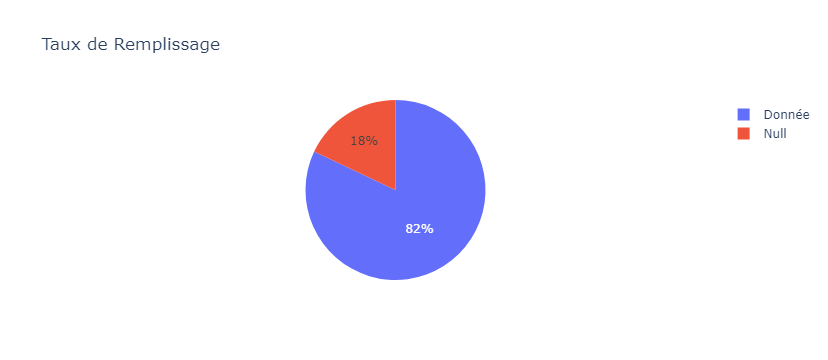

<Figure size 1500x800 with 0 Axes>

In [78]:
Pie_chart2(df_prev)

In [79]:
#nan_control(df_prev)

In [80]:
df_prev.describe(include = 'all')

SK_ID_PREV    SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY  AMT_APPLICATION    AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY   CNT_PAYMENT  NAME_YIELD_GROUP  PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL
count   1.670214e+06  1.670214e+06            1670214  1.297979e+06     1.670214e+06  1.670213e+06      7.743700e+05     1.284699e+06                    1670214             1.670214e+06  ...              1670214  1.297984e+06           1670214              1669868       997149.000000  997149.000000             997149.000000  997149.000000    997149.000000             997149.000000
unique           NaN           NaN                  4           NaN              NaN           NaN               NaN              NaN                          7                      NaN  ...                   11           NaN                 5                   17                 NaN            NaN                       NaN            NaN              NaN                       NaN
top              NaN           NaN         Cash loans           NaN              NaN           NaN               NaN              NaN                    TUESDAY                      NaN  ...                  XNA           NaN               XNA                 Cash                 NaN            NaN                       NaN            NaN              NaN                       NaN
freq             NaN           NaN             747553           NaN              NaN           NaN               NaN              NaN                     255118                      NaN  ...               855720           NaN            517215               285990                 NaN            NaN                       NaN            NaN              NaN                       NaN
mean    1.923089e+06  2.783572e+05                NaN  1.595512e+04     1.752339e+05  1.961140e+05      6.697402e+03     2.278473e+05                        NaN             1.248418e+01  ...                  NaN  1.605408e+01               NaN                  NaN       342209.855039   13826.269337              33767.774054   76582.403064     81992.343838                  0.332570
std     5.325980e+05  1.028148e+05                NaN  1.478214e+04     2.927798e+05  3.185746e+05      2.092150e+04     3.153966e+05                        NaN             3.334028e+00  ...                  NaN  1.456729e+01               NaN                  NaN        88916.115833   72444.869708             106857.034789  149647.415123    153303.516729                  0.471134
min     1.000001e+06  1.000010e+05                NaN  0.000000e+00     0.000000e+00  0.000000e+00     -9.000000e-01     0.000000e+00                        NaN             0.000000e+00  ...                  NaN  0.000000e+00               NaN                  NaN        -2922.000000   -2892.000000              -2801.000000   -2889.000000     -2874.000000                  0.000000
25%     1.461857e+06  1.893290e+05                NaN  6.321780e+03     1.872000e+04  2.416050e+04      0.000000e+00     5.084100e+04                        NaN             1.000000e+01  ...                  NaN  6.000000e+00               NaN                  NaN       365243.000000   -1628.000000              -1242.000000   -1314.000000     -1270.000000                  0.000000
50%     1.923110e+06  2.787145e+05                NaN  1.125000e+04     7.104600e+04  8.054100e+04      1.638000e+03     1.123200e+05                        NaN             1.200000e+01  ...                  NaN  1.200000e+01               NaN                  NaN       365243.000000    -831.000000               -361.000000    -537.000000      -499.000000                  0.000000
75%     2.384280e+06  3.675140e+05                NaN  2.065842e+04     1.803600e+05  2.164185e+05      7.740000e+03     2.340000e+05                        NaN          

In [81]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

# MERGE ALL DATASETS

In [8]:
preprocess_data_home_credit_default('Home_credit_risk_data_modeling')

Train samples: 307511, test samples: 48744
Main df init shape: (356251, 247)
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)
Main df final shape: (356251, 797)
Function executed in : 270.7008376121521 s
